In [2]:
using PhyloNetworks
using PhyloPlots
using Combinatorics
using Formatting

In [25]:
trees = readMultiTopology("data/rawdata/one.trees");
tree = trees[4]

HybridNetwork, Rooted Network
6 edges
7 nodes: 4 tips, 0 hybrid nodes, 3 internal tree nodes.
tip labels: 4, 1, 2, 3
(4:4.249,(1:2.457,(2:2.064,3:2.064):0.393):1.793);


In [26]:
[e.length for e in tree.edge]

6-element Vector{Float64}:
 4.249
 2.457
 2.064
 2.064
 0.393
 1.793

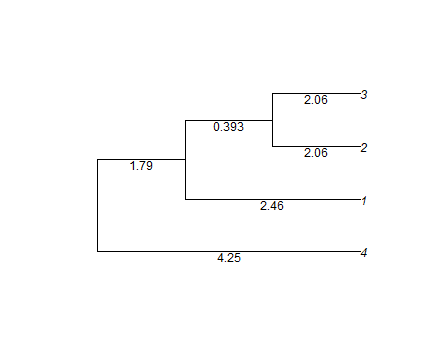

In [27]:
plot(tree, :R, showEdgeLength=true);

In [28]:
function num_bipartitions(n)
    return 2^(n-1) - 1
end;

In [29]:
# is there prinf with variable length in julia?

function show_bipartitions(n, start=0, stop=nothing)
    idx_width = length(string(num_bipartitions(n)))
    idx_fmt = FormatSpec(string(">", idx_width, "s"))
    node_width = length(string(n))
    node_fmt = fmt = FormatSpec(string(">", node_width, "s"))
    idx = 0
    node = Vector(1:n)
    println("idx\tpartition")
    for i in range(1, n÷2)
        
        comb = combinations(Vector(1:n), i)
        if i == n - i
            comb = Iterators.take(comb,  binomial(n,i)÷ 2)
        end
            
        for c in comb
            if start <= idx && (stop === nothing || idx <= stop)
                printfmt(idx_fmt, idx)
                print("\t")
                for e in c
                    printfmt(node_fmt, e)
                    print(" ")
                end
                print("| ")
                for e in sort(collect(setdiff(node ,Set(c))))
                    printfmt(node_fmt, e)
                    print(" ")
                end
                println()
            end
            idx += 1
        end
    end
end;

function show_bipartition(n, idx)
    show_bipartitions(n,idx,idx)
end;



In [41]:
show_bipartitions(4)
show_bipartition(4, 4)

idx	partition
0	1 | 2 3 4 
1	2 | 1 3 4 
2	3 | 1 2 4 
3	4 | 1 2 3 
4	1 2 | 3 4 
5	1 3 | 2 4 
6	1 4 | 2 3 
idx	partition
4	1 2 | 3 4 


In [52]:
# get the nodes that the branch has. 
function get_nodes(idx)
    nodes = []
    for i in 1:length(idx)
        if idx[i]
            append!(nodes, i)
        end
    end
    return nodes
end


function get_bipartition(tree, n)
    taxa = sort(tipLabels(tree))
    if length(taxa) != n
        print("check the parameter n")
        return
    end
    node = Vector(1:n)
    result = []
    idx = 0
    for i in tree.edge
        node_idx = hardwiredCluster(i,taxa)
        branch_node = get_nodes(node_idx)
        
        # if branch seperates more than half nodes, we use the small part to get bipartition idx
        if (length(branch_node) > n ÷ 2)
             branch_node = sort(collect(setdiff(node,branch_node)))
        end
        
        # generate all possible combination with the same number of nodes
        comb = collect(combinations(Vector(1:n), length(branch_node)))
        for c in 1:length(comb)
            if comb[c] == branch_node
                # if the combination is the later, we need to find its first half
                if length(branch_node) > 1 && c > length(comb) ÷ 2
                    c = length(comb) - c + 1 
                end
                idx = c - 1
                break
            end
        end
        for j in 1:(length(branch_node) - 1)
            idx = idx + binomial(n,j)
        end
        push!(result,Pair(idx, i.length))
        idx = 0
    end
    return result
end;

In [53]:
get_bipartition(tree, 4)

6-element Vector{Any}:
 3 => 4.249
 0 => 2.457
 1 => 2.064
 2 => 2.064
 6 => 0.393
 3 => 1.793

In [190]:
function print_bipartition(trees, n)
    
    # build the table
    N = num_bipartitions(n)
    data = zeros(length(trees), N)
    treeNum = 1;
    # get existing index
    
    for i in trees
        bipart = get_bipartition(i, n)
        for j in 1:length(bipart)
            data[treeNum,(bipart[j][1] + 1)] += bipart[j][2]
        end
        treeNum+=1
    end
    return data
end;

print_bipartition (generic function with 1 method)

In [202]:
using CSV, DataFrames

function print_csv(path, n, target)
    tree = readMultiTopology(path)
    result = print_bipartition(tree, n)
    N = num_bipartitions(n)
    header = Vector(0:N - 1)
    header = string.(header)
    CSV.write(target, DataFrame(result, :auto),header = header) 
end;

In [208]:
print_csv("data/rawdata/one.trees", 4, "data/one.csv");
print_csv("data/rawdata/two.trees", 4, "data/two.csv");

In [209]:
print_csv("data/rawdata/8_taxa_1.trees", 8, "data/8_one.csv");
print_csv("data/rawdata/8_taxa_2.trees", 8, "data/8_two.csv");

In [210]:
print_csv("data/rawdata/5_taxa_1.trees", 5, "data/5_one.csv");